# Neural network to solve the Schrödinger equation

## Bayesiansk inferens och maskininlärning [TIF385], Chalmers, lp2 2024

Building from the ground up a Neural Network to solve the Schrödinger equation with implementation of classes in python.

### Modulimport

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import pandas as pd

# Bulding the class Neural_Network

In [2]:
class Neural_Network(object):
    
    def __init__(self, insize=2, outsize=1, hiddensize=3, output='linear'):
        #Define Hyperparameters
        self.inputLayerSize = insize
        self.outputLayerSize = outsize
        self.hiddenLayerSize = hiddensize
        if output=='linear':
            self.output = self.linear
            self.outputPrime = self.linearPrime
        elif output=='sigmoid':
            self.output = self.sigmoid
            self.outputPrime = self.sigmoidPrime

        # Initialize weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
    def forward(self, X):
        """
        Propogate inputs through network
        
        Note: 
        refer to weight arrays as 
        self.W1
        self.W2
        
        and the hidden layer output
        self.y1
        
        and activations
        self.z1
        self.z2       
        """

        self.z1 = np.matmul(X, self.W1)
        self.y1 = self.sigmoid(self.z1)
        self.z2 = np.matmul(self.y1, self.W2)
        
        return self.output(self.z2)

    def linear(self, z):
        """Apply linear activation function to scalar, vector, or matrix"""
        return z

    def linearPrime(self,z):
        """Gradient of linear with respect to z"""
        return np.ones_like(z)

    def sigmoid(self, z):
        """Apply sigmoid activation function to scalar, vector, or matrix"""
        return 1/(1+np.exp(-z))

    def sigmoidPrime(self,z):
        """Gradient of sigmoid with respect to z"""
        return np.exp(-z)/(1+np.exp(-z))**2

    def costFunction(self, X, y):
        """Compute cost for given X,y, use weights already stored in class."""
        self.yHat = self.forward(X)
        C = 0.5*sum((y-self.yHat)**2)
        return C
    
    def delta_output(self, y):
        return np.multiply(-(y-self.yHat), self.outputPrime(self.z2))

    def costFunctionPrime(self, X, y):
        """Compute derivative with respect to W and W2 for a given X and y"""
        self.yHat = self.forward(X)

        # Derivative of output layer with respect to z2
        delta2 = self.delta_output(y)
        dCdW2 = np.dot(self.y1.T, delta2)

        delta1 = np.dot(delta2, self.W2.T)*self.sigmoidPrime(self.z1)
        dCdW1 = np.dot(X.T, delta1)

        return dCdW1, dCdW2

    #Helper Functions for interacting with other classes:
    def getParams(self):
        """Get W1 and W2 unrolled into a single array"""
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params

    def setParams(self, params):
        """Set W1 and W2 using a single parameter array."""
        W1_start = 0
        W1_end = self.hiddenLayerSize * self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize , self.hiddenLayerSize)
                            )
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))
  
    def computeGradients(self, X, y):
        dCdW1, dCdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dCdW1.ravel(), dCdW2.ravel()))

# Class to train the Neural Network

In [3]:
class Trainer(object):
    
    def __init__(self, N, maxiter=200, disp=True):
        """
        Initialize an object for training of a neural network.
        
        Args:
            N: reference to an instance of the Neural_Network class.
            maxiter: maximum number of iterations for the BFGS optimization (default: 200).
            disp: verbose output from optimization (default: True)
        """
        self.N = N
        self.maxiter = maxiter
        self.disp = disp

    def callbackF(self, params):
        self.N.setParams(params)
        self.C.append(self.N.costFunction(self.X, self.y))
        self.train_score.append(self.score(self.X, self.y))
        if not (self.yval is None or self.Xval is None):
            self.val_score.append(self.score(self.Xval, self.yval))

    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        return cost, grad
    
    def score(self, X, y):
        """
        MSE score
        
        Evaluate the NN output 'yhat' for input X 
        and compare with the observed output 'y'
        """
        yhat = self.N.forward(X)
        MSE = np.mean((yhat-y)**2)
        return MSE

    def train(self, X, y, Xval=None, yval=None):
        """Make internal variables for the callback function"""
        self.X = X
        self.y = y
        self.Xval = Xval
        self.yval = yval

        #Make empty list to store costs:
        self.C = []
        self.train_score = []
        self.val_score = []

        params0 = self.N.getParams()

        
        options = {'maxiter': self.maxiter, 'disp' : self.disp}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(X, y), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res

### Downloading the data

In [4]:

trainx = np.load("trainx_step3.npy")
trainy = np.load("trainy_step3.npy")
validx = np.load("validx_step3.npy")
validy = np.load("validy_step3.npy")
print("Shape of training data x: {} Shape of training data y: {} Shape of test data x: {} Shape of test data y: {}".format(np.shape(trainx), np.shape(trainy), np.shape(validx), np.shape(validy)))

Shape of training data x: (400, 127) Shape of training data y: (400, 1) Shape of test data x: (69, 127) Shape of test data y: (69, 1)


In [5]:
maxiter=300

#Chose 10 hidden layers as adding more layers did not lead to a substantial improvement of the model while also increasing the risk of overfitting.
#The total number of parameters then becomes 10(127 + 1) = 1280. Max iterations were also increased as experimenting with the model showed that the neural network adapted better to both training data and validation data.

Neural = Neural_Network(127, 1, 10)
opt = Trainer(Neural, maxiter=maxiter)
opt.train(trainx, trainy, validx, validy)



         Current function value: 0.030538
         Iterations: 300
         Function evaluations: 304
         Gradient evaluations: 304


c:\Users\carlo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


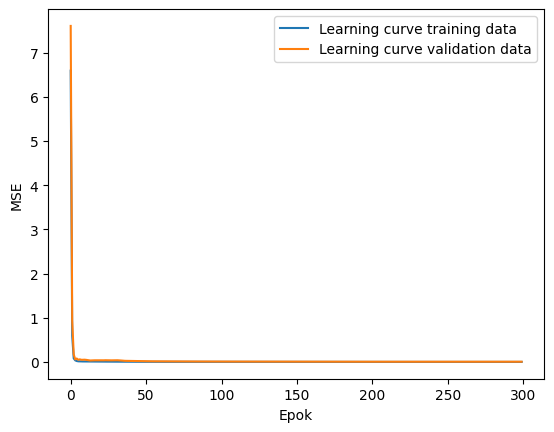

In [6]:

plt.plot(opt.train_score, label="Learning curve training data")
plt.plot(opt.val_score, label="Learning curve validation data")
plt.xlabel("Epok")
plt.ylabel("MSE")
plt.legend()
plt.show()






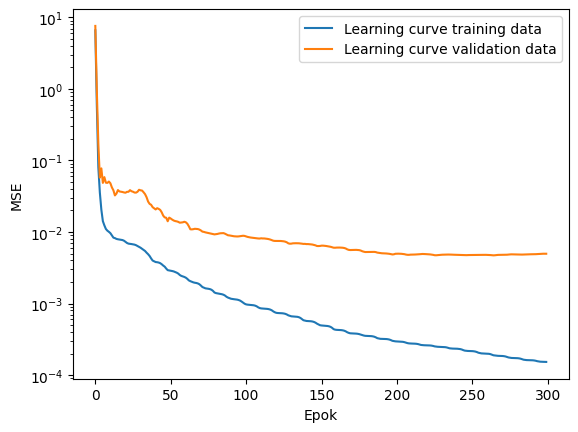

In [7]:
plt.plot(opt.train_score, label="Learning curve training data")
plt.plot(opt.val_score, label="Learning curve validation data")
plt.xlabel("Epok")
plt.ylabel("MSE")
plt.yscale("log")
plt.legend()
plt.show()

#There are small signs of overfitting as the validation data has some local peak values, but no substantial overfitting since the validation data never starts to rise significantly

In [8]:

y_hat_train = Neural.forward(trainx)
y_hat_valid = Neural.forward(validx)



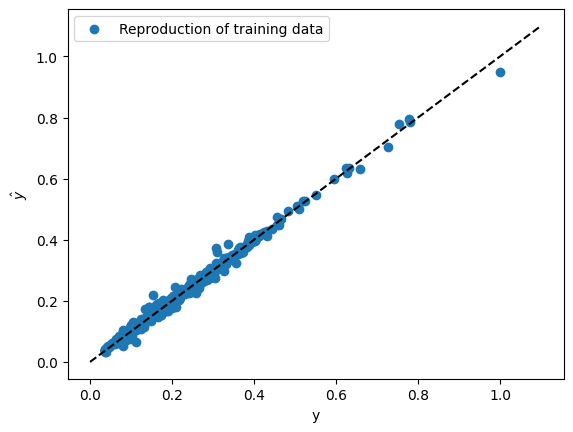

In [9]:
x = np.linspace(0, 1.1, 100)
plt.plot(x, x, color="black", linestyle="--")
plt.scatter(trainy, y_hat_train, label="Reproduction of training data")
plt.xlabel("y")
plt.ylabel(r"$\hat{y}$")
plt.legend()
plt.show()

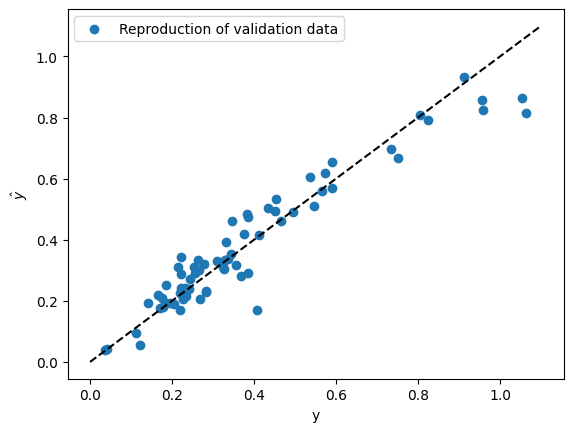

In [10]:

plt.plot(x, x, color="black", linestyle="--")
plt.scatter(validy, y_hat_valid, label="Reproduction of validation data")
plt.xlabel("y")
plt.ylabel(r"$\hat{y}$")
plt.legend()
plt.show()


#There are some signs of biased data as the model performs worse for higher energy levels, and we have trained it on lower energy levels
